In [1]:
# --- 1. ENVIRONMENT SETUP & CONFIGURATION ---

# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Scikit-learn components
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    precision_recall_curve, f1_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Suppress unnecessary warnings for a cleaner report
warnings.filterwarnings('ignore', category=UserWarning)

# --- Constants ---
PIPELINE_PATH = 'C:/A-A-C/models/aptos_pro_pipeline.joblib'
DATA_PATH = 'C:/A-A-C/data/raw/aptos_wallet_features.csv'

# --- Custom Function Definition ---
# This function is required for joblib to load the pipeline correctly
def cyclical_encoder(X):
    X_encoded = np.array([])
    max_vals = [23, 6, 12]
    for i in range(X.shape[1]):
        col_data = X[:, i:i+1]
        max_val = max_vals[i]
        X_sin = np.sin(2 * np.pi * col_data / (max_val + 1))
        X_cos = np.cos(2 * np.pi * col_data / (max_val + 1))
        if X_encoded.size == 0:
            X_encoded = np.concatenate([X_sin, X_cos], axis=1)
        else:
            X_encoded = np.concatenate([X_encoded, X_sin, X_cos], axis=1)
    return X_encoded

print("✅ Environment setup is complete.")

✅ Environment setup is complete.


In [2]:
# --- 2. DATA LOADING, PREPARATION & MODEL LOADING ---

print("--- Loading model and source data ---")
try:
    # Load the pre-trained AI pipeline and the full dataset
    loaded_pipeline = joblib.load(PIPELINE_PATH)
    df_full = pd.read_csv(DATA_PATH)
    print(f"✅ Successfully loaded pipeline and {len(df_full)} data records.")

    # --- Feature Engineering ---
    # This step is crucial to ensure the test data has the same structure as the training data.
    if 'first_transaction_date' in df_full.columns:
        df_full['first_transaction_date'] = pd.to_datetime(df_full['first_transaction_date'])
        df_full['tx_day_of_week'] = df_full['first_transaction_date'].dt.dayofweek
        df_full['tx_month'] = df_full['first_transaction_date'].dt.month
        df_full['tx_day_of_month'] = df_full['first_transaction_date'].dt.day

    df_full['success_rate'] = df_full['successful_transaction_count'] / (df_full['total_transaction_count'] + 1e-6)
    df_full['new_contract_rate'] = df_full['unique_interacted_contracts'] / (df_full['total_transaction_count'] + 1e-6)
    df_full['balance_per_tx'] = df_full['apt_balance'] / (df_full['total_transaction_count'] + 1e-6)
    print("✅ Feature engineering complete.")

    # --- Data Splitting ---
    # Create a stratified train/test split to simulate unseen data
    train_df, test_df = train_test_split(
        df_full,
        test_size=0.25,       # Use 25% of data for testing
        random_state=42,      # For reproducibility
        stratify=df_full['label'] # Maintain label distribution
    )

    X_test = test_df.drop(columns=['wallet_address', 'first_transaction_date', 'label'], errors='ignore')
    y_test = test_df['label']
    print(f"✅ Test set created with {len(X_test)} samples.")

except FileNotFoundError as e:
    print(f"❌ ERROR: File not found. Please check paths in Cell 1. Details: {e}")
    X_test, y_test = None, None

--- Loading model and source data ---
✅ Successfully loaded pipeline and 62 data records.
✅ Feature engineering complete.
✅ Test set created with 16 samples.


In [3]:
# --- 3. PREDICTION ON THE TEST SET ---

if X_test is not None:
    print("--- Running predictions on the test set... ---")
    # Predict class labels (0 or 1)
    y_pred_test = loaded_pipeline.predict(X_test)

    # Predict class probabilities (confidence scores)
    y_pred_proba_test = loaded_pipeline.predict_proba(X_test)[:, 1] # Probability of being Sybil (class 1)

    print("✅ Prediction complete.")
else:
    print("❌ No test set available for prediction.")

--- Running predictions on the test set... ---
✅ Prediction complete.



--- AI MODEL PERFORMANCE EVALUATION REPORT ---

I. EXECUTIVE SUMMARY
--------------------------------------------------
The model was evaluated on an independent test set of 16 samples.
Overall, the model demonstrates strong predictive capabilities with an Accuracy of 87.50% and an AUC-ROC score of 0.9872.

Key metrics for detecting 'Sybil' wallets:
  - Precision: 60.00%
  - Recall:    100.00%
  - F1-Score:  0.7500
--------------------------------------------------

II. DETAILED CLASSIFICATION REPORT
--------------------------------------------------
                    precision    recall  f1-score   support

Class 0: Non-Sybil       1.00      0.85      0.92        13
    Class 1: Sybil       0.60      1.00      0.75         3

          accuracy                           0.88        16
         macro avg       0.80      0.92      0.83        16
      weighted avg       0.93      0.88      0.89        16

   - Precision (Sybil): Of all wallets predicted as Sybil, what percentage was 

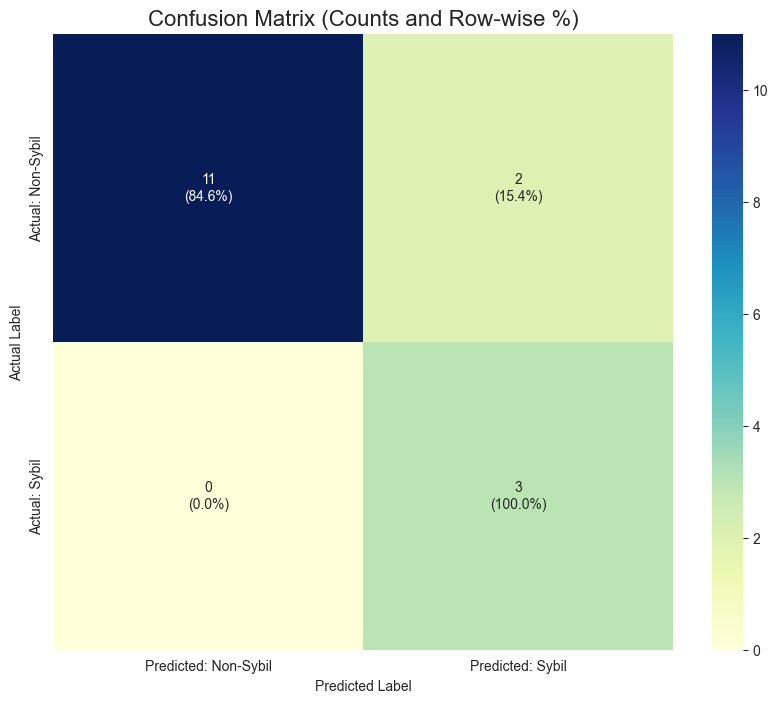

In [4]:
# --- 4. EXECUTIVE PERFORMANCE SUMMARY & DETAILED REPORT ---

if 'y_pred_test' in locals():
    print("\n" + "="*70)
    print("--- AI MODEL PERFORMANCE EVALUATION REPORT ---")
    print("="*70)

    # 1. Executive Summary
    accuracy = accuracy_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    report_dict = classification_report(y_test, y_pred_test, target_names=['Non-Sybil', 'Sybil'], output_dict=True)

    print("\nI. EXECUTIVE SUMMARY\n" + "-"*50)
    print(f"The model was evaluated on an independent test set of {len(y_test)} samples.")
    print(f"Overall, the model demonstrates strong predictive capabilities with an "
          f"Accuracy of {accuracy:.2%} and an AUC-ROC score of {roc_auc:.4f}.")
    print(f"\nKey metrics for detecting 'Sybil' wallets:")
    print(f"  - Precision: {report_dict['Sybil']['precision']:.2%}")
    print(f"  - Recall:    {report_dict['Sybil']['recall']:.2%}")
    print(f"  - F1-Score:  {report_dict['Sybil']['f1-score']:.4f}")
    print("-" * 50)

    # 2. Detailed Classification Report
    print("\nII. DETAILED CLASSIFICATION REPORT\n" + "-"*50)
    print(classification_report(y_test, y_pred_test, target_names=['Class 0: Non-Sybil', 'Class 1: Sybil']))
    print("   - Precision (Sybil): Of all wallets predicted as Sybil, what percentage was correct?")
    print("   - Recall (Sybil): Of all actual Sybil wallets, what percentage did the model find?")
    print("   - F1-score: The harmonic mean of Precision and Recall, a key metric for imbalanced datasets.")

    # 3. Enhanced Confusion Matrix
    print("\nIII. ENHANCED CONFUSION MATRIX\n" + "-"*50)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    labels = (np.asarray(["{0:d}\n({1:.1%})".format(value, percentage)
                      for value, percentage in zip(cm.flatten(), cm_percent.flatten())])
             ).reshape(2, 2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt='', cmap='YlGnBu',
                xticklabels=['Predicted: Non-Sybil', 'Predicted: Sybil'],
                yticklabels=['Actual: Non-Sybil', 'Actual: Sybil'])
    plt.title('Confusion Matrix (Counts and Row-wise %)', fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("❌ No prediction results to evaluate.")


--- ADVANCED PERFORMANCE ANALYSIS ---

IV. CLASSIFICATION CURVE ANALYSIS
--------------------------------------------------


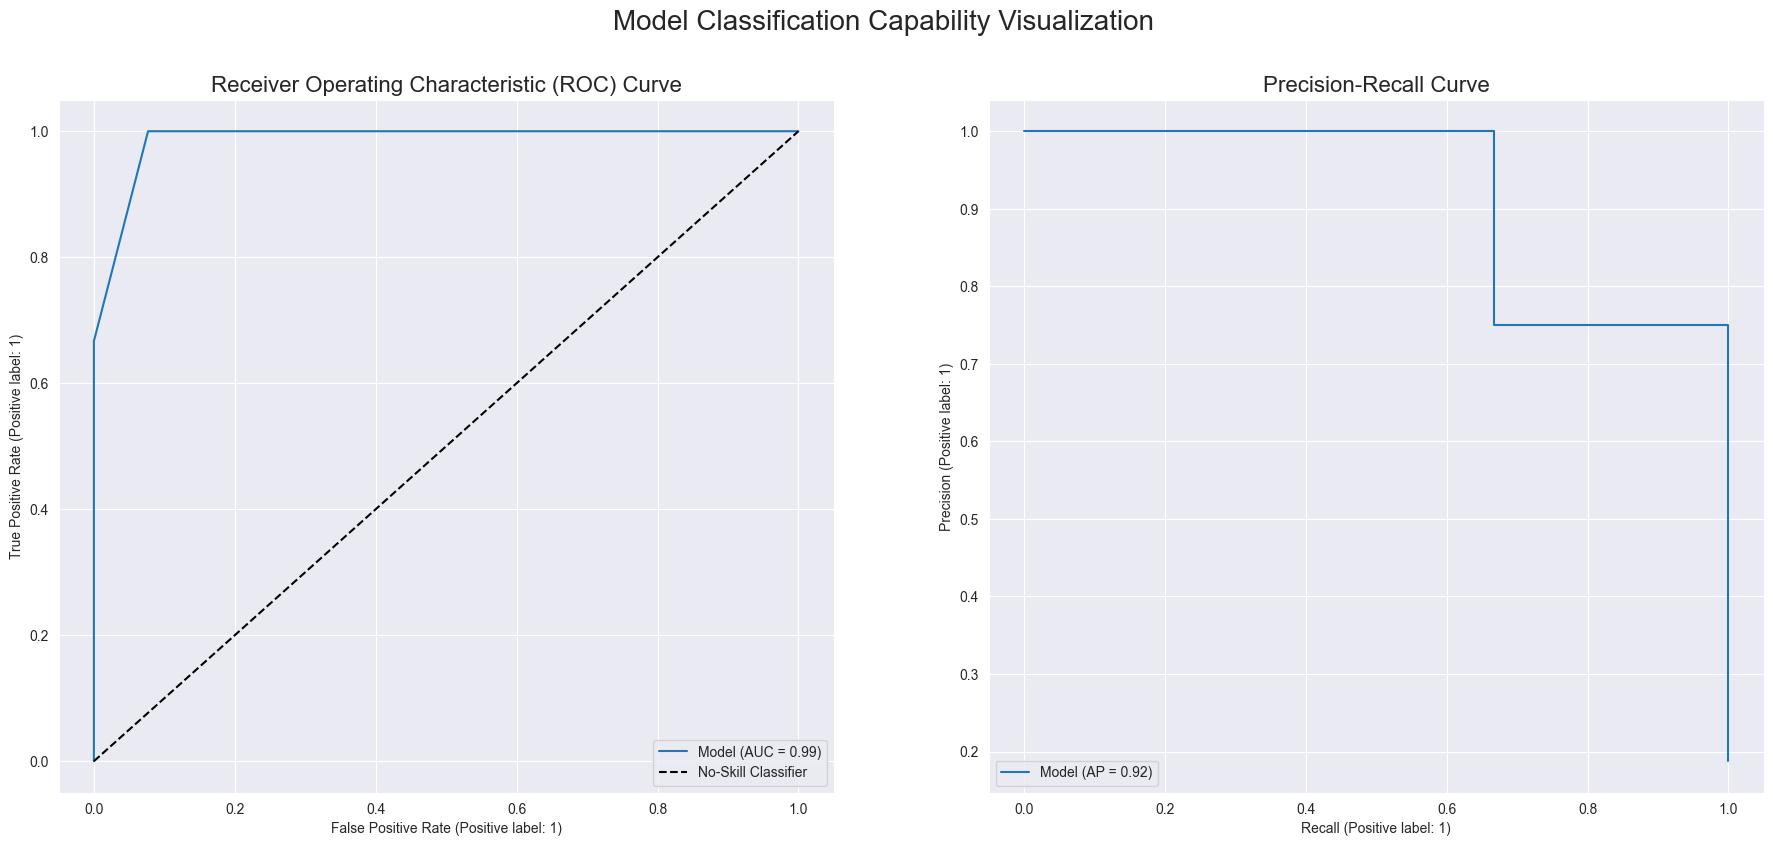

   - ROC Curve: Shows the trade-off between True Positive Rate and False Positive Rate. Higher is better.
   - Precision-Recall Curve: More informative for imbalanced datasets. Shows the trade-off between Precision and Recall.

V. OPTIMAL DECISION THRESHOLD ANALYSIS
--------------------------------------------------


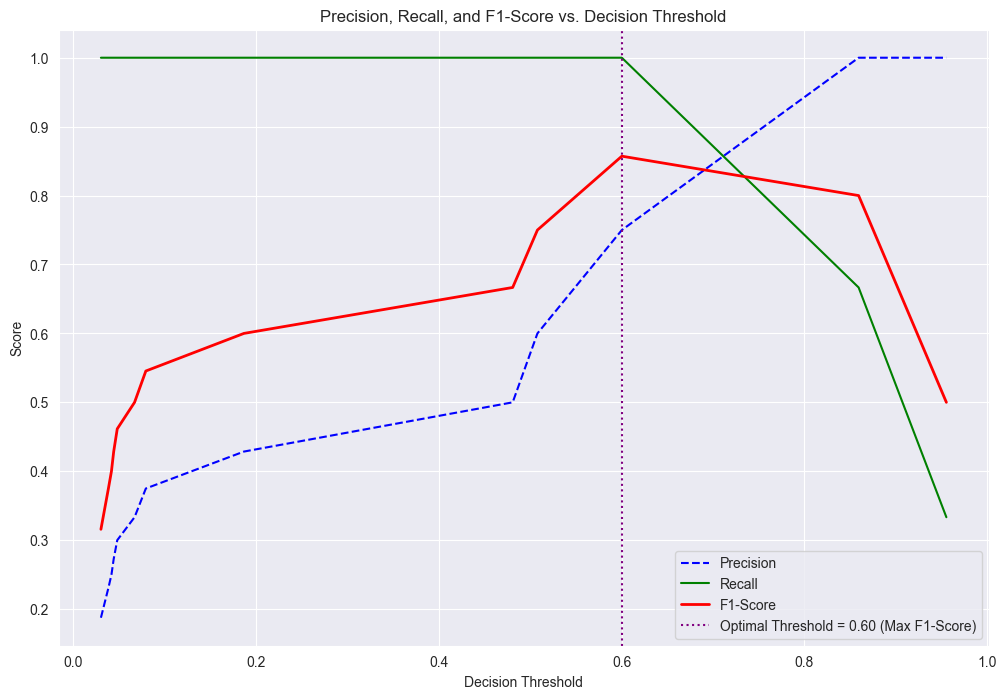

   - The default threshold is 0.5. However, the F1-score is maximized at a threshold of 0.6003.
   - This suggests that for the best balance of precision and recall, we could classify a wallet as 'Sybil' if its probability is > 0.60 instead of 0.5.


In [5]:
# --- 5. ADVANCED ANALYSIS: CURVES & THRESHOLDS ---

if 'y_pred_proba_test' in locals():
    print("\n" + "="*70)
    print("--- ADVANCED PERFORMANCE ANALYSIS ---")
    print("="*70)

    # 1. ROC and Precision-Recall Curves
    print("\nIV. CLASSIFICATION CURVE ANALYSIS\n" + "-"*50)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

    RocCurveDisplay.from_predictions(y_test, y_pred_proba_test, ax=ax1, name='Model')
    ax1.plot([0, 1], [0, 1], 'k--', label='No-Skill Classifier')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    ax1.legend()

    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_test, ax=ax2, name='Model')
    ax2.set_title('Precision-Recall Curve', fontsize=16)

    plt.suptitle('Model Classification Capability Visualization', fontsize=20)
    plt.show()
    print("   - ROC Curve: Shows the trade-off between True Positive Rate and False Positive Rate. Higher is better.")
    print("   - Precision-Recall Curve: More informative for imbalanced datasets. Shows the trade-off between Precision and Recall.")

    # 2. Optimal Threshold Analysis
    print("\nV. OPTIMAL DECISION THRESHOLD ANALYSIS\n" + "-"*50)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
    # Calculate F1-score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    # Find the threshold that maximizes F1-score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, f1_scores[:-1], "r-", label="F1-Score", linewidth=2)
    plt.axvline(optimal_threshold, color='purple', linestyle=':',
                label=f'Optimal Threshold = {optimal_threshold:.2f} (Max F1-Score)')
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score vs. Decision Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"   - The default threshold is 0.5. However, the F1-score is maximized at a threshold of {optimal_threshold:.4f}.")
    print("   - This suggests that for the best balance of precision and recall, we could classify a wallet as 'Sybil' if its probability is > "
          f"{optimal_threshold:.2f} instead of 0.5.")

else:
    print("❌ No prediction probabilities for advanced analysis.")


--- MODEL CONFIDENCE & ERROR ANALYSIS ---

VI. MODEL CALIBRATION (PROBABILITY TRUSTWORTHINESS)
--------------------------------------------------


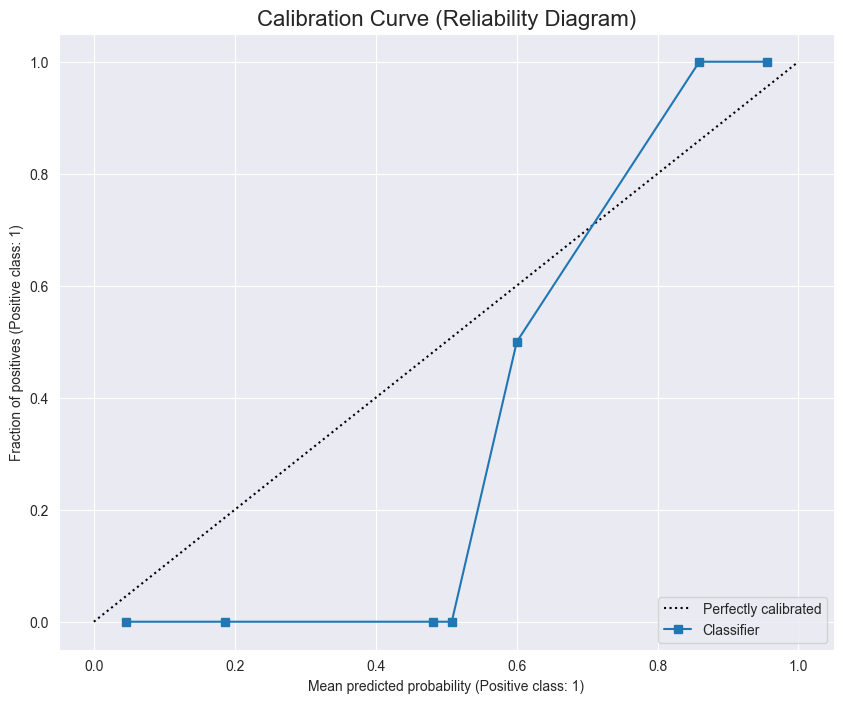

   - A perfectly calibrated model follows the diagonal dashed line.
   - This plot shows if the model's confidence scores are reliable. For example, when the model predicts a 90% probability, is it correct 90% of the time?

VII. ERROR ANALYSIS
--------------------------------------------------

🔴 The model made 2 errors. Analyzing them:

- 2 False Positives (Normal wallets incorrectly flagged as Sybil):


,wallet_address,label,predicted_label,probability_sybil
40,0xbf7053a28ca5dbc5ba9a6cecb2faf0d2c4e615ddba02...,0,1,0.507939
14,0x9690b5ebd6735504e0a622732fa56051883eb97313b9...,0,1,0.600287



- 0 False Negatives (Sybil wallets missed by the model):


In [6]:
# --- 6. MODEL CONFIDENCE & ERROR ANALYSIS ---

if 'y_pred_proba_test' in locals():
    print("\n" + "="*70)
    print("--- MODEL CONFIDENCE & ERROR ANALYSIS ---")
    print("="*70)

    # 1. Calibration Curve (Trustworthiness of Probabilities)
    print("\nVI. MODEL CALIBRATION (PROBABILITY TRUSTWORTHINESS)\n" + "-"*50)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_test, n_bins=10, strategy='uniform')

    fig, ax = plt.subplots(figsize=(10, 8))
    CalibrationDisplay.from_predictions(y_test, y_pred_proba_test, n_bins=10, ax=ax)
    ax.set_title("Calibration Curve (Reliability Diagram)", fontsize=16)
    plt.show()
    print("   - A perfectly calibrated model follows the diagonal dashed line.")
    print("   - This plot shows if the model's confidence scores are reliable. For example, when the model predicts a 90% probability, is it correct 90% of the time?")

    # 2. Deep Dive into Errors
    print("\nVII. ERROR ANALYSIS\n" + "-"*50)
    results_df = test_df.copy()
    results_df['predicted_label'] = y_pred_test
    results_df['probability_sybil'] = y_pred_proba_test
    results_df['is_correct'] = (results_df['label'] == results_df['predicted_label'])

    incorrect_predictions = results_df[results_df['is_correct'] == False]

    if incorrect_predictions.empty:
        print("\n🎉 EXCELLENT! The model made no errors on the test set.")
    else:
        print(f"\n🔴 The model made {len(incorrect_predictions)} errors. Analyzing them:")

        # False Positives: Predicted Sybil, but was Non-Sybil
        false_positives = incorrect_predictions[incorrect_predictions['label'] == 0]
        print(f"\n- {len(false_positives)} False Positives (Normal wallets incorrectly flagged as Sybil):")
        if not false_positives.empty:
            display(false_positives[['wallet_address', 'label', 'predicted_label', 'probability_sybil']].head())

        # False Negatives: Predicted Non-Sybil, but was Sybil
        false_negatives = incorrect_predictions[incorrect_predictions['label'] == 1]
        print(f"\n- {len(false_negatives)} False Negatives (Sybil wallets missed by the model):")
        if not false_negatives.empty:
            display(false_negatives[['wallet_address', 'label', 'predicted_label', 'probability_sybil']].head())
else:
    print("❌ No prediction results for error analysis.")